# Board game analysis - Looking for similarities

To perform the analysis is necessary to import some Py libraries and the dataset as a Pandas Dataframe.
Pandas is a data manipulation library,
Matplotlib is a plotting library,
Seaborn is a visualization library based on matplotlib,
Numpy add support for vectors ,multidimensional matrix and other usefull mathematical functions.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
%matplotlib inline
import scipy.stats as st

First of all I've imported the dataset as a pandas dataframe and I started exploring data:

In [2]:
df = pd.read_csv('./bgg_db_2017_04.csv', encoding='latin1')

I analyse the first columns and the information inside in order to find some interesting analysis.

In [3]:
df.head()

,rank,bgg_url,game_id,names,min_players,max_players,avg_time,min_time,max_time,year,avg_rating,geek_rating,num_votes,image_url,age,mechanic,owned,category,designer,weight
0,1,https://boardgamegeek.com/boardgame/161936/pan...,161936,Pandemic Legacy: Season 1,2,4,60,60,60,2015,8.66905,8.48904,18009,https://cf.geekdo-images.com/images/pic2452831...,13,"Action Point Allowance System, Co-operative Pl...",29472,"Environmental, Medical","Rob Daviau, Matt Leacock",2.8076
1,2,https://boardgamegeek.com/boardgame/182028/thr...,182028,Through the Ages: A New Story of Civilization,2,4,240,180,240,2015,8.72977,8.30744,7309,https://cf.geekdo-images.com/images/pic2663291...,14,"Action Point Allowance System, Auction/Bidding...",10007,"Card Game, Civilization, Economic",Vlaada Chvátil,4.3093
2,3,https://boardgamegeek.com/boardgame/12333/twil...,12333,Twilight Struggle,2,2,180,180,180,2005,8.35745,8.22021,27403,https://cf.geekdo-images.com/images/pic361592.jpg,13,"Area Control / Area Influence, Campaign / Batt...",37382,"Modern Warfare, Political, Wargame","Ananda Gupta, Jason Matthews",3.5317
3,4,https://boardgamegeek.com/boardgame/120677/ter...,120677,Terra Mystica,2,5,150,60,150,2012,8.29627,8.15458,24267,https://cf.geekdo-images.com/images/pic1356616...,12,"Route/Network Building, Variable Phase Order, ...",27948,"Civilization, Economic, Fantasy, Territory Bui...","Jens Drögemüller, Helge Ostertag",3.9387
4,5,https://boardgamegeek.com/boardgame/174430/glo...,174430,Gloomhaven,1,4,150,90,150,2017,9.08970,8.15151,3978,https://cf.geekdo-images.com/images/pic2437871...,12,"Action / Movement Programming, Campaign / Batt...",6057,"Adventure, Economic, Exploration, Fantasy, Fig...",Isaac Childres,3.7028


In [4]:
total_row = len(df.index)
print(total_row)

4999


# Let's explore the dataset

How many players is most frequent. Here I'm adding two column at the end of dataset: average numbers of players and the players number range (min - max). With this we can wich category is most frequent and look for same easy correlation:

In [5]:
df['avg_players'] = (df['min_players'] + df['max_players']) / 2
df['player_number'] = df['min_players'].astype(str) + '-' + df['max_players'].astype(str)

# Average player histogram:

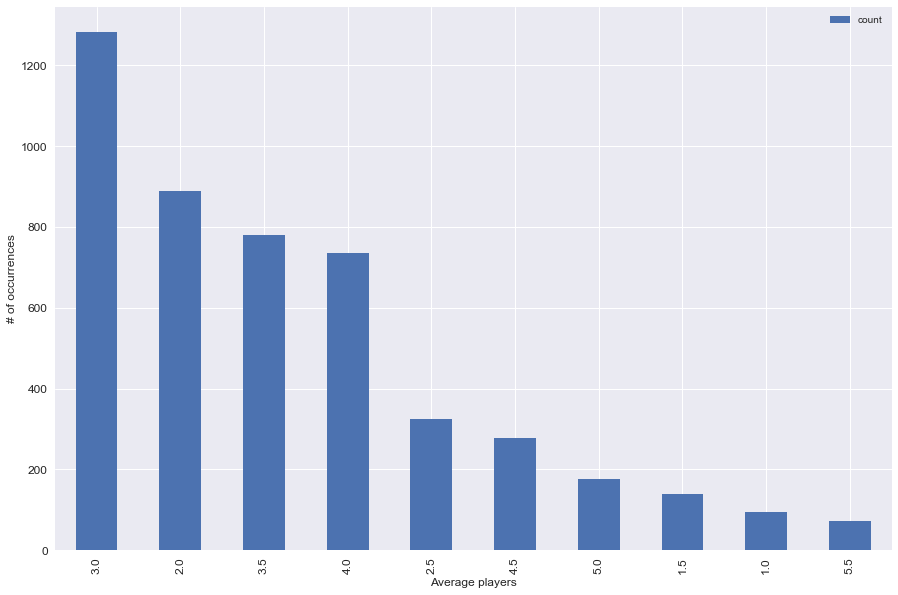

In [6]:
avg_pl=df.groupby(['avg_players']).size().to_frame('count').reset_index()
avg_pl = avg_pl.sort_values(['count'], ascending=[False])
ax = avg_pl[['avg_players','count']].head(10).plot(kind='bar', x=['avg_players'], title ="", figsize=(15, 10), legend=True, fontsize=12)
ax.set_xlabel("Average players", fontsize=12)
ax.set_ylabel("# of occurrences", fontsize=12)
plt.show()

# Player range histogram:

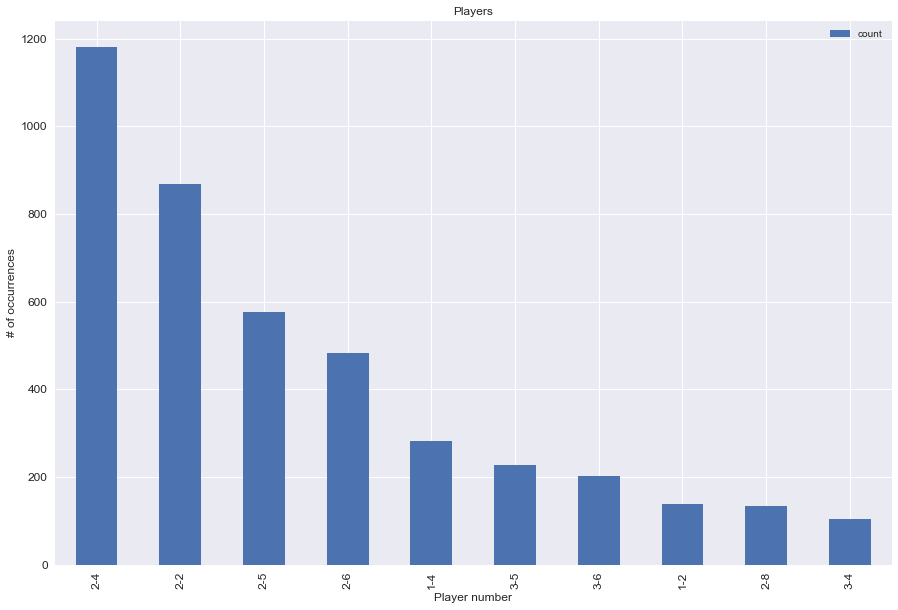

In [7]:
net=df.groupby(['player_number']).size().to_frame('count').reset_index()
net_sorted = net.sort_values(['count'], ascending=[False])
ax = net_sorted[['player_number','count']].head(10).plot(kind='bar', x=['player_number'], title ="Players", figsize=(15, 10), legend=True, fontsize=12)
ax.set_xlabel("Player number", fontsize=12)
ax.set_ylabel("# of occurrences", fontsize=12)
plt.show()

2-4 is the most common player range followed by 2 players. Let's explore these building separated dataframe for the main five occurrencies:

In [8]:
table_2_4 = df.loc[df['player_number'] == '2-4']
table_2_2 = df.loc[df['player_number'] == '2-2']
table_2_5 = df.loc[df['player_number'] == '2-5']
table_2_6 = df.loc[df['player_number'] == '2-6']
table_1_4 = df.loc[df['player_number'] == '1-4']

And is possible to see wich games are inside the histogram bars:

In [9]:
table_2_4['names'].head()

0                         Pandemic Legacy: Season 1
1     Through the Ages: A New Story of Civilization
5                              Star Wars: Rebellion
10                          The Castles of Burgundy
12                 War of the Ring (Second Edition)
Name: names, dtype: object

The first five column are the most common:

In [10]:
row_sum = len(table_2_4.index)+len(table_2_2.index)+len(table_2_5.index)+len(table_2_6.index)+len(table_1_4.index);
percentage=row_sum/total_row*100
print(percentage)

67.83356671334266


They represent the 68% of the overall data.

# Most common age:

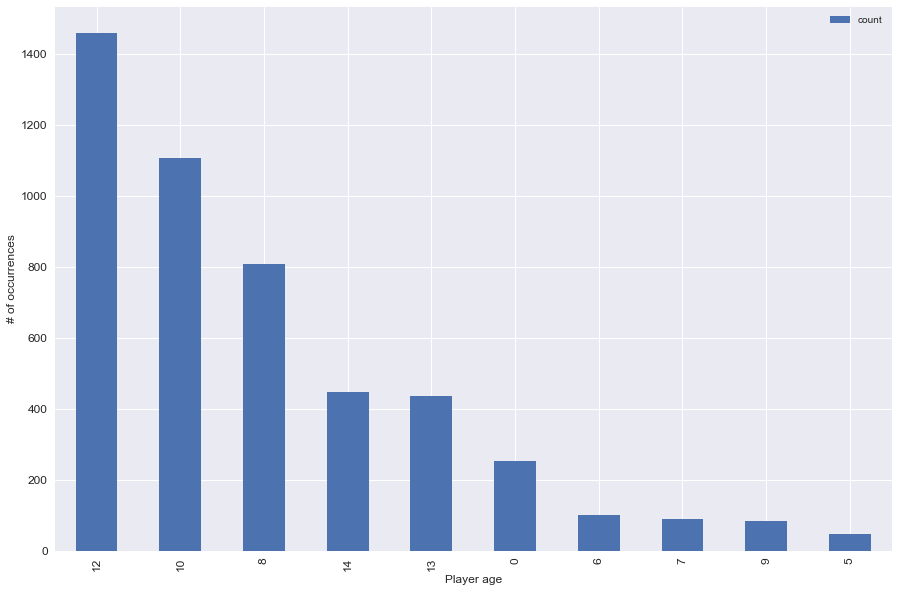

In [11]:
age_count=df.groupby(['age']).size().to_frame('count').reset_index()
age_count = age_count.sort_values(['count'], ascending=[False])
ax = age_count[['age','count']].head(10).plot(kind='bar', x=['age'], title ="", figsize=(15, 10), legend=True, fontsize=12)
ax.set_xlabel("Player age", fontsize=12)
ax.set_ylabel("# of occurrences", fontsize=12)
plt.show()

Again if we want which games are inside the bar:

In [12]:
table_age_12 = df.loc[df['age'] == 12]
table_age_12['names'].head()

3                 Terra Mystica
4                    Gloomhaven
7             Terraforming Mars
9     Caverna: The Cave Farmers
10      The Castles of Burgundy
Name: names, dtype: object

# Correlation between age and the complexity of the game (weight):

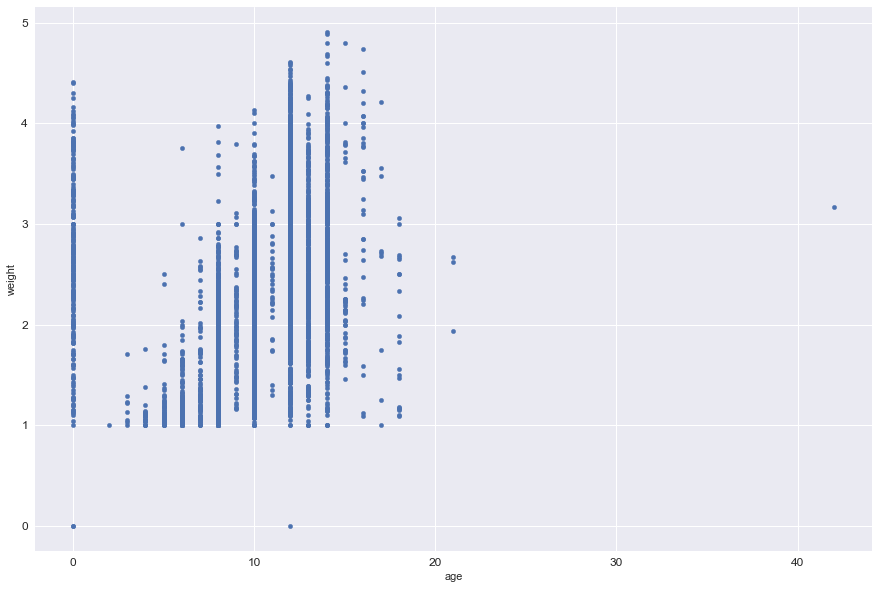

In [13]:
ax = df.plot(kind='scatter', x='age',y='weight', title ="", figsize=(15, 10), legend=True, fontsize=12)

The Pearson correlation is not so strong:

In [14]:
np.corrcoef(df['age'],df['weight'])[0,1]

0.29589483531355137

# Correlation between average rating and weight (how complex the game is):

There is a correlation between complexity and rating? 

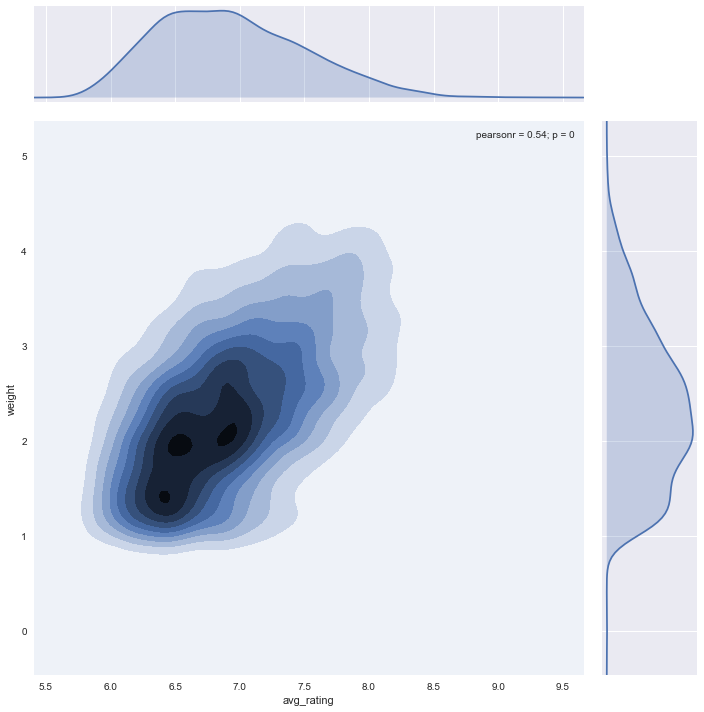

In [15]:
ax = sb.jointplot(x='avg_rating', y='weight',data=df,kind='kde', size=10) 

The pearson correlation coefficient is 0.54 so there is a linear correlation between weight and average rating. If we use Geek rating the correlation crash to 0.19. Why? The reason is the geek rating is the average rating adjusted for the number of votes. If there are only a few votes, it's pulled strongly towards the middle (5.5 is the number used, I think). If there are a lot of votes, the geek rating is closer to the average rating.

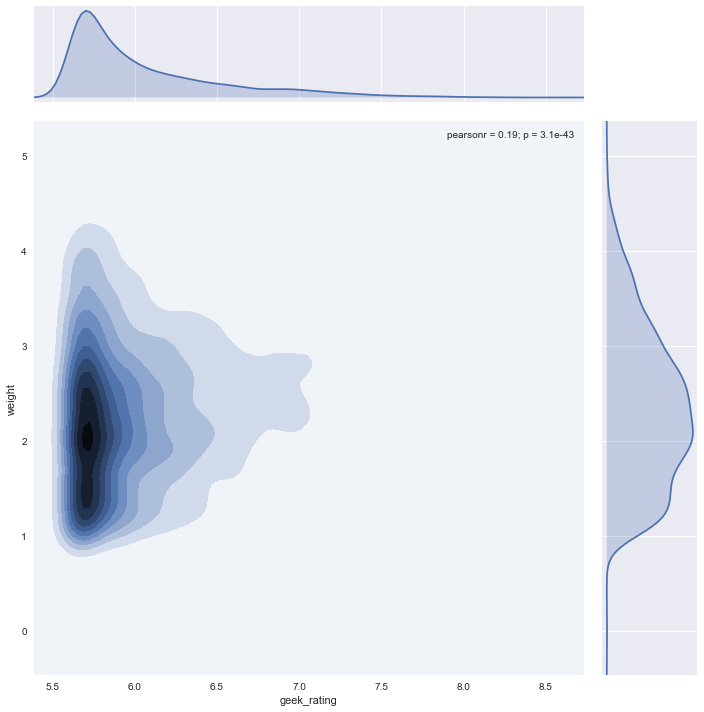

In [16]:
ax = sb.jointplot(x='geek_rating', y='weight',data=df,kind='kde', size=10) 

Now I take only very high number of votes (more than 5000 votes):

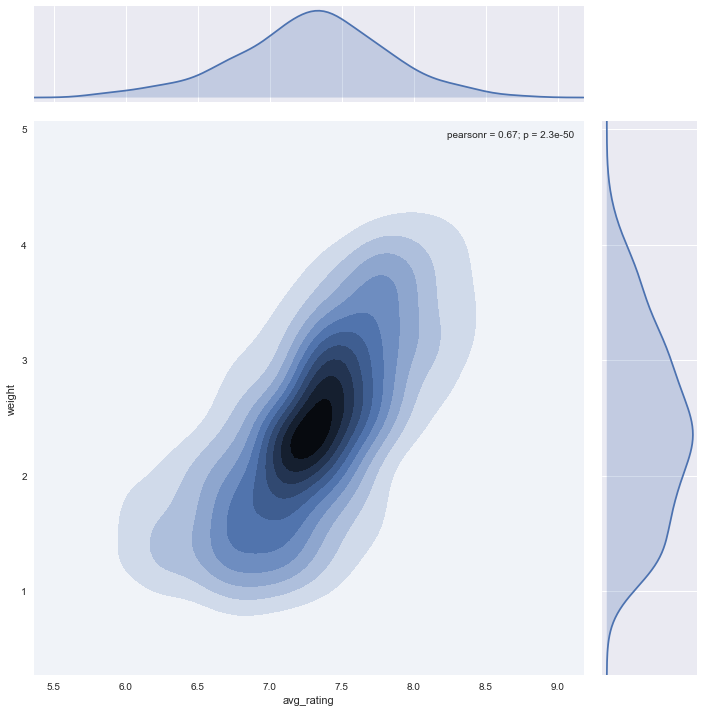

In [17]:
df_stat_sig = df.loc[df['num_votes'] >= 5000]
ax = sb.jointplot(x='avg_rating', y='weight',data=df_stat_sig,kind='kde', size=10) 

In [18]:
len(df_stat_sig)

375

There are only 375 boardgame but the correlation is more clear and high (0.67)

# For a given game which other games are most similar:

Now I'm building the array with the values of a generic game that I want to compare with the others.

In [19]:
data = np.zeros((1,), dtype=[('names', 'U25'),('min_players', 'int'),('max_players', 'int'),('avg_time', 'float')
                             ,('min_time', 'int'),('max_time', 'int'),('avg_rating', 'float'),
                             ('geek_rating', 'float'),('age', 'int'),('weight', 'float'),('avg_players', 'float')])

data[:] = [('My Game',1,6,180,30,180,7.8,5.7,10,3.6,3.5)]

my_game = pd.DataFrame(data)


In [20]:
my_game.head()

,names,min_players,max_players,avg_time,min_time,max_time,avg_rating,geek_rating,age,weight,avg_players
0,My Game,1,6,180.0,30,180,7.8,5.7,10,3.6,3.5


Now I need to clean my dataframe with only the columns that describe numerically the characteristics of the games:

In [21]:
game_for_model = df.drop(['rank','bgg_url','game_id','num_votes','image_url','mechanic','owned','category','designer','player_number','year'], axis=1)

In [22]:
game_for_model.head(1)

,names,min_players,max_players,avg_time,min_time,max_time,avg_rating,geek_rating,age,weight,avg_players
0,Pandemic Legacy: Season 1,2,4,60,60,60,8.66905,8.48904,13,2.8076,3.0


The idea at the base of this model is to compute the spearman rank correlation in order to find which games are most similar:

In [23]:
spearman = []
for k in range(total_row):
    spearman.append(st.spearmanr(my_game[my_game.columns[1:]].loc[0],game_for_model[game_for_model.columns[1:]].iloc[k])[0])

Here I compute pearson and spearman correlation. Spearman rank correlation asses how well the relationship between two variables can be described using a monotonic function. Pearson correlation coefficient is a measure of the linear correlation between two variables.

In [24]:
pearson = []
for k in range(total_row):
    pearson.append(st.pearsonr(my_game[my_game.columns[1:]].loc[0],game_for_model[game_for_model.columns[1:]].iloc[k])[0])

Here I'm creating a new dataframe called "game_spear". Is a copy of the "game_for_model" dataframe but I want to add at the end the two column spearman and pearson correlation. The reason is to maintain the whole original dataset as is in order to be free to change "my_game" and perform other analysis with another mock game.

In [25]:
game_spear = game_for_model.copy(deep=True)

In [26]:
game_spear['spearman'] = spearman
game_spear['pearson'] = pearson

Sorting values by Spearman Rank Correlation:

In [27]:
game_spear_sort = game_spear.sort_values(['spearman'], ascending=[False])

In [28]:
game_spear_sort.head(10)

,names,min_players,max_players,avg_time,min_time,max_time,avg_rating,geek_rating,age,weight,avg_players,spearman,pearson
3253,Perdition's Mouth: Abyssal Rift,1,6,180,30,180,7.84903,5.75840,10,3.6923,3.5,1.000000,1.000000
825,World in Flames,2,7,6000,120,6000,7.49972,6.51085,12,4.5984,4.5,1.000000,0.995271
4421,La Grande Guerre 14-18,2,6,3600,360,3600,7.80366,5.65713,14,4.9048,4.0,1.000000,0.998983
3233,Air Superiority,1,6,60,60,60,6.73137,5.75997,12,3.8529,3.5,0.990811,0.825951
2180,Advanced Third Reich,2,6,2480,2480,2480,6.73067,5.94674,12,4.5268,4.0,0.990811,0.827243
4265,18C2C: Manifest Destiny,2,6,600,600,600,7.66346,5.66588,14,4.6667,4.0,0.990811,0.827471
2491,Terrible Swift Sword,2,6,4320,4320,4320,7.27310,5.88251,12,4.1579,4.0,0.990811,0.827217
3337,The Three Days of Gettysburg (third edition),1,6,75,75,75,7.43000,5.74868,12,4.2444,3.5,0.990811,0.827010
3993,Firepower,1,6,60,60,60,6.11407,5.68513,12,3.6667,3.5,0.990811,0.825931
2666,Imperium Romanum II,1,6,240,240,240,6.57530,5.84771,16,3.7647,3.5,0.990811,0.827741


Here a list of the first 10 most similar games by the Spearman correlation. If we have a look at linear correlation instead:

In [29]:
game_pear = game_spear.sort_values(['pearson'], ascending=[False])

In [30]:
game_pear.head(10)

,names,min_players,max_players,avg_time,min_time,max_time,avg_rating,geek_rating,age,weight,avg_players,spearman,pearson
3253,Perdition's Mouth: Abyssal Rift,1,6,180,30,180,7.84903,5.75840,10,3.6923,3.5,1.000000,1.000000
2095,Apex Theropod Deck-Building Game,1,6,290,45,290,7.37977,5.96809,14,2.9565,3.5,0.987805,0.999946
1903,V-Commandos,1,4,180,30,180,8.23187,6.02263,12,2.7143,2.5,0.987805,0.999897
4857,"Silver Bayonet: The First Team in Vietnam, 1965",2,2,300,45,300,6.72197,5.63308,12,3.0435,2.0,0.925996,0.999836
865,Historia,1,6,180,30,180,7.04943,6.48562,14,3.1136,3.5,0.975610,0.999833
9,Caverna: The Cave Farmers,1,7,210,30,210,8.17949,8.00663,12,3.7883,4.0,0.975610,0.999804
2499,Comanchería: The Rise and Fall of the Comanche...,1,1,360,60,360,8.32032,5.88144,14,3.9600,1.0,0.925996,0.999790
103,Go,2,2,180,30,180,7.67240,7.41118,8,3.9730,2.0,0.925996,0.999753
3671,Pericles: The Peloponnesian Wars,1,4,360,45,360,8.52372,5.71214,12,3.8571,2.5,0.987805,0.999644
3474,D-Day at Peleliu,1,2,480,60,480,8.34227,5.73319,12,3.8571,1.5,0.963415,0.999618


# Cosine similarity

Cosine similarity is a measure of similarity between two non-zero vectors of an inner product space that measures the cosine of the angle between them. Cosine similarity then gives a useful measure (in text mining) of how similar two documents are likely to be in terms of their subject matter. I will define the cosine similarity in the function below:

In [31]:
def square_rooted(x):
 
    return round(np.sqrt(sum([a*a for a in x])),3)
 
def cosine_similarity(x,y):
 
    numerator = sum(a*b for a,b in zip(x,y))
    denominator = square_rooted(x)*square_rooted(y)
    return round(numerator/float(denominator),3)

And now I could apply it to the dataset:

In [32]:
cosine = []
for k in range(total_row):
    cosine.append(cosine_similarity(my_game[my_game.columns[1:]].loc[0],game_for_model[game_for_model.columns[1:]].iloc[k]))

Add the Cosine column to the results table:

In [33]:
game_spear['cosine'] = cosine

In [34]:
game_cosine = game_spear.sort_values(['cosine'], ascending=[False])

In [35]:
game_cosine.head(10)

,names,min_players,max_players,avg_time,min_time,max_time,avg_rating,geek_rating,age,weight,avg_players,spearman,pearson,cosine
865,Historia,1,6,180,30,180,7.04943,6.48562,14,3.1136,3.5,0.975610,0.999833,1.000
9,Caverna: The Cave Farmers,1,7,210,30,210,8.17949,8.00663,12,3.7883,4.0,0.975610,0.999804,1.000
1903,V-Commandos,1,4,180,30,180,8.23187,6.02263,12,2.7143,2.5,0.987805,0.999897,1.000
2095,Apex Theropod Deck-Building Game,1,6,290,45,290,7.37977,5.96809,14,2.9565,3.5,0.987805,0.999946,1.000
3253,Perdition's Mouth: Abyssal Rift,1,6,180,30,180,7.84903,5.75840,10,3.6923,3.5,1.000000,1.000000,1.000
76,Nations,1,5,200,40,200,7.75364,7.50628,14,3.5375,3.0,0.987805,0.999538,1.000
103,Go,2,2,180,30,180,7.67240,7.41118,8,3.9730,2.0,0.925996,0.999753,1.000
3586,The King's Armory,1,7,240,30,240,7.21975,5.72076,13,3.1765,4.0,0.987805,0.999550,1.000
109,Hannibal: Rome vs. Carthage,2,2,200,40,200,7.82870,7.38253,12,3.4168,2.0,0.925996,0.999383,1.000
2499,Comanchería: The Rise and Fall of the Comanche...,1,1,360,60,360,8.32032,5.88144,14,3.9600,1.0,0.925996,0.999790,0.999


# Manhattan Distance (Taxicab geometry)

Taxicab geometry is a form of geometry in which the usual distance function or metric of Euclidean geometry is replaced by a new metric in which the distance between two points is the sum of the absolute differences of their Cartesian coordinates. Is defined by:

In [36]:
def manhattan_distance(x,y):
 
    return sum(abs(a-b) for a,b in zip(x,y))

In [37]:
manhattan = []
for k in range(total_row):
    manhattan.append(manhattan_distance(my_game[my_game.columns[1:]].loc[0],game_for_model[game_for_model.columns[1:]].iloc[k]))

As usual I add and sort it to the result table

In [38]:
game_spear['manhattan'] = manhattan

In [39]:
game_taxi = game_spear.sort_values(['manhattan'], ascending=[True])

In [40]:
game_taxi.head(10)

,names,min_players,max_players,avg_time,min_time,max_time,avg_rating,geek_rating,age,weight,avg_players,spearman,pearson,cosine,manhattan
3253,Perdition's Mouth: Abyssal Rift,1,6,180,30,180,7.84903,5.75840,10,3.6923,3.5,1.000000,1.000000,1.000,0.19973
865,Historia,1,6,180,30,180,7.04943,6.48562,14,3.1136,3.5,0.975610,0.999833,1.000,6.02259
1903,V-Commandos,1,4,180,30,180,8.23187,6.02263,12,2.7143,2.5,0.987805,0.999897,1.000,6.64020
103,Go,2,2,180,30,180,7.67240,7.41118,8,3.9730,2.0,0.925996,0.999753,1.000,10.71178
986,Warfighter: The Tactical Special Forces Card Game,1,6,180,30,180,7.83828,6.39718,0,2.7125,3.5,0.719512,0.999085,0.999,11.62296
266,Zombicide,1,6,180,45,180,7.31930,7.07652,13,2.5873,3.5,0.975610,0.997847,0.998,20.86992
4252,Aventuria Adventure Card Game,1,4,180,45,180,7.51786,5.66655,14,2.0000,2.5,0.975610,0.997599,0.998,23.91559
2207,Risk Europe,2,4,180,45,180,7.83625,5.93913,14,2.4545,3.0,0.975610,0.997690,0.998,23.92088
98,Zombicide: Black Plague,1,6,180,60,180,7.95424,7.42260,10,2.5948,3.5,0.975610,0.991517,0.993,32.88204
185,Dune,2,6,180,60,180,7.61598,7.21567,12,3.4345,4.0,0.975610,0.991719,0.993,35.36519


# Conclusion

Let's remember how my_game vector is:

In [41]:
my_game

,names,min_players,max_players,avg_time,min_time,max_time,avg_rating,geek_rating,age,weight,avg_players
0,My Game,1,6,180.0,30,180,7.8,5.7,10,3.6,3.5


There are many different data mining techniques applicable at this example. 

In this case we search similarities through Spearman Rank Correlation, Pearson Linear Correlation, Cosine Similarities and Manhattan Distance. 
Spearman Rank Correlation assesses how well the relationship between two variables can be described using a monotonic function. 
Cosine similarity is a good technique but is used to measure cohesion within clusters and in text recognition (in these fields probably is more powerfull). 
Manhattan Distance also is a good indicator of how much two point are far, and in our case probably the best.  

In [48]:
game_spear = game_spear.sort_values((['manhattan']), ascending=[True])
game_spear.head(10)

,names,min_players,max_players,avg_time,min_time,max_time,avg_rating,geek_rating,age,weight,avg_players,spearman,pearson,cosine,manhattan
3253,Perdition's Mouth: Abyssal Rift,1,6,180,30,180,7.84903,5.75840,10,3.6923,3.5,1.000000,1.000000,1.000,0.19973
865,Historia,1,6,180,30,180,7.04943,6.48562,14,3.1136,3.5,0.975610,0.999833,1.000,6.02259
1903,V-Commandos,1,4,180,30,180,8.23187,6.02263,12,2.7143,2.5,0.987805,0.999897,1.000,6.64020
103,Go,2,2,180,30,180,7.67240,7.41118,8,3.9730,2.0,0.925996,0.999753,1.000,10.71178
986,Warfighter: The Tactical Special Forces Card Game,1,6,180,30,180,7.83828,6.39718,0,2.7125,3.5,0.719512,0.999085,0.999,11.62296
266,Zombicide,1,6,180,45,180,7.31930,7.07652,13,2.5873,3.5,0.975610,0.997847,0.998,20.86992
4252,Aventuria Adventure Card Game,1,4,180,45,180,7.51786,5.66655,14,2.0000,2.5,0.975610,0.997599,0.998,23.91559
2207,Risk Europe,2,4,180,45,180,7.83625,5.93913,14,2.4545,3.0,0.975610,0.997690,0.998,23.92088
98,Zombicide: Black Plague,1,6,180,60,180,7.95424,7.42260,10,2.5948,3.5,0.975610,0.991517,0.993,32.88204
185,Dune,2,6,180,60,180,7.61598,7.21567,12,3.4345,4.0,0.975610,0.991719,0.993,35.36519


Manhattan distance is able to catch also very low differencies the correlation indicator or cosine are not so efficient.
To a very low manhattan distance is associated, in general, a high pearson correlation coefficient:

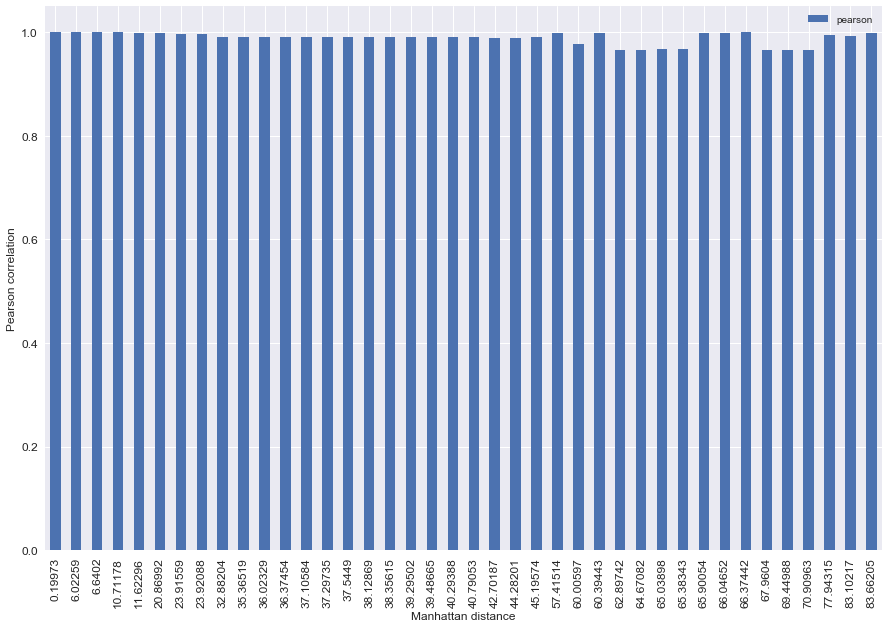

In [64]:
ax = game_spear[['manhattan','pearson']].head(40).plot(kind='bar', x=['manhattan'], title ="", figsize=(15, 10), legend=True, fontsize=12)
ax.set_xlabel("Manhattan distance", fontsize=12)
ax.set_ylabel("Pearson correlation", fontsize=12)
plt.show()